Random seed used for this run: 365219


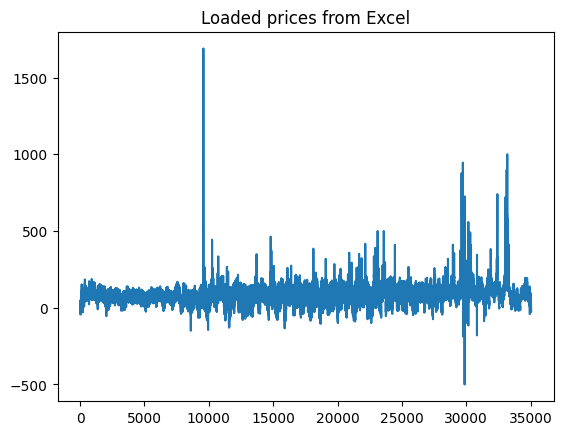

/usr/local/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning:

WARN: Box bound precision lowered by casting to float32

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Loaded previous model successfully.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1182 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------
| time/              |      |
|    fps             | 1182 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 835         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013094474 |
|    clip_fraction        | 0.12   

Final profit with battery: 56,113.12 €



Final profit WITH battery (RL): €56,113.12
Battery efficiency: 0.9


In [16]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO
import plotly.graph_objects as go
import plotly.express as px
import openpyxl
import random

seed = random.randint(0, 1000000)
print(f"Random seed used for this run: {seed}")

np.random.seed(seed)
random.seed(seed)

import torch
torch.manual_seed(seed)

# -----------------------------------------------
# LOAD EXCEL DATA
# -----------------------------------------------

excel_path = "/Users/administrator/Documents/Christian_meyer_energy_consulting/untitled folder/batterie project 2024 v2.xlsx"
df_excel = pd.read_excel(excel_path, skiprows=16)

production = df_excel["Production (kWh)"].values
prices = df_excel["Euro/MWh"].values

# Quick plot to check:
plt.plot(prices)
plt.title("Loaded prices from Excel")
plt.show()

# -----------------------------------------------
# ENVIRONMENT
# -----------------------------------------------

class BatteryEnv(gym.Env):
    def __init__(self, prices, production,
                 capacity_kwh=500.0,
                 charge_rate=225.0,
                 discharge_rate=225.0,
                 efficiency=0.9):
        super().__init__()
        self.prices = prices
        self.production = production
        self.T = len(prices)
        self.capacity = capacity_kwh
        self.charge_rate = charge_rate
        self.discharge_rate = discharge_rate
        self.eff = efficiency
        self.steps_per_day = 96  # 15-min steps
        self.prev_action = None
        self.prev_price = None
        self.discharge_count = 0
        self.prev_delta_reward = 0.0
        self.delta_reward = 0.0
        
        self.low_price_threshold = np.percentile(prices, 15)
        self.high_price_threshold = np.percentile(prices, 75)
        self.mean_price = np.mean(prices)/1000

        max_price = np.max(prices)
        max_prod = np.max(production)
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0]),
            high=np.array([max_price, max_prod, 1.0]),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: charge, 1: hold, 2: discharge
    def seed(self, seed=None):
        np.random.seed(seed)
        random.seed(seed)
        try:
            import torch
            torch.manual_seed(seed)
        except ImportError:
            pass
    def reset(self):
        self.t = 0
        self.soc = 0.0
        self.total_profit = 0.0
        self.total_soc = 0.0
        self.total_energy_charged = 0.0
        self.total_energy_discharged = 0.0
        self.prev_action = None
        self.prev_price = None
        self.prev_delta_reward = 0.0
        self.discharge_count = 0
        obs = np.array([self.prices[self.t], self.production[self.t], self.soc], dtype=np.float32)
        return obs

    def step(self, action):
        price = self.prices[self.t]
        actual_production = self.production[self.t]
        
        # reset discharge count every 24 hours
        if self.t % self.steps_per_day == 0:
            self.discharge_count = 0
        
        CHARGE = 0
        HOLD = 1
        DISCHARGE = 2

        # Initialize penalty to 0
        penalty = 0

        # Skip step if no production (night)
        if actual_production == 0:
            self.t += 1
            done = self.t >= self.T
            next_price = self.prices[min(self.t, self.T-1)]
            next_prod = self.production[min(self.t, self.T-1)]
            obs = np.array([next_price, next_prod, self.soc], dtype=np.float32)
            info = dict(
                skip=True,
                soc=self.soc,
                reward=0,
                profit=0,
                price=price,
                action="skip",
                cumulative_profit=self.total_profit
            )
            return obs, 0, done, info

        # Otherwise proceed normally
        profit = 0
        energy_charged = 0.0
        energy_discharged = 0.0
        charge_bonus = 0.0

        if action == CHARGE:
            available_capacity = self.capacity * (1.0 - self.soc)
            charge_amount = min(self.charge_rate, available_capacity, actual_production)
            energy_charged = charge_amount
            excess_prod = actual_production - charge_amount

            self.soc += (charge_amount / self.capacity) * self.eff
            self.soc = np.clip(self.soc, 0.0, 1.0)

            if price > 0:
                profit += excess_prod * price / 1000
            LOW_PRICE_THRESHOLD = 60
            LOW_PRICE_BONUS = 15.0
            
            if action == CHARGE and (0 < price <= LOW_PRICE_THRESHOLD):
                charge_bonus = LOW_PRICE_BONUS * (LOW_PRICE_THRESHOLD - price) / LOW_PRICE_THRESHOLD
              

        elif action == DISCHARGE:
            available_energy = self.capacity * self.soc
            discharge_amount = min(self.discharge_rate, available_energy)
            energy_discharged = discharge_amount

            revenue_from_discharge = price * discharge_amount/1000
            self.soc -= (discharge_amount / self.capacity) / self.eff
            self.soc = np.clip(self.soc, 0.0, 1.0)

            revenue_from_prod = price * actual_production/1000
            profit += revenue_from_discharge + revenue_from_prod

            #penalty for low price discharge closer to charge price
            

        elif action == HOLD:
            revenue = price * actual_production/1000 
            profit += revenue
            

    
        reward = profit + charge_bonus

        # Update previous action and price
        self.prev_action = action
        self.prev_price = price

        # Penalty for non-HOLD actions
        if action != HOLD:
            penalty = -5  # Small penalty for cycling
            reward += penalty

        # Normalize reward
        

        # Update total profit
        self.total_profit += profit
        
        self.total_energy_charged += energy_charged
        self.total_energy_discharged += energy_discharged
        self.total_soc += (abs(energy_discharged) + abs(energy_charged))/ self.capacity

        self.t += 1
        done = self.t >= self.T

        next_price = self.prices[min(self.t, self.T-1)]
        next_prod = self.production[min(self.t, self.T-1)]
        obs = np.array([next_price, next_prod, self.soc], dtype=np.float32)

        info = dict(
            soc=self.soc,
            energy_charged=energy_charged,
            energy_discharged=energy_discharged,
            reward=reward,
            price=price,
            action=int(action),
            profit=profit,
            cumulative_profit=self.total_profit,
            yearly_cycle = self.total_soc
        )

        return obs, reward, done, info

# -----------------------------------------------
# TRAIN MODEL
# -----------------------------------------------

env = BatteryEnv(prices, production)
try:
    model = PPO.load("ppo_battery_model_bonus_removed", env=env, verbose=1, seed=seed)
    print("✅ Loaded previous model successfully.")
except FileNotFoundError:
    print("⚠️ No previous model found. Training from scratch.")
model = PPO("MlpPolicy", env, verbose=1, seed=seed)

# Now train
model.learn(total_timesteps=200_000)
model.save("ppo_battery_model_bonus_removed")

print("Training complete.")

# -----------------------------------------------
# EVALUATE TRAINED AGENT
# -----------------------------------------------

obs = env.reset()
records = []

for t in range(len(prices)):
    action, _ = model.predict(obs, deterministic=True)
    next_obs, reward, done, info = env.step(action)

    if info.get("skip", False):
        obs = next_obs
        continue

    records.append({
        "t": t,
        "price": obs[0],
        "production": obs[1],
        "soc": obs[2],
        "action": action,
        "reward": reward,
        "cumulative_profit": info["cumulative_profit"],
        "total_soc": info["yearly_cycle"],
        "energy_charged": info["energy_charged"],
        "energy_discharged": info["energy_discharged"],
    })

    obs = next_obs
    if done:
        break

df = pd.DataFrame(records)
df.to_csv("battery_rl_results.csv", index=False)


# -----------------------------------------------
# PLOT
# -----------------------------------------------

fig1 = go.Figure()
fig1.add_trace(go.Scattergl(
    y=df['cumulative_profit'],
    mode='lines',
    name='Cumulative Profit (€)',
    line=dict(color='blue')
))
fig1.update_layout(
    title='Cumulative Profit over Time',
    yaxis_title='€',
    xaxis_title='1/4 Hour',
    template='plotly_white'
)
fig1.show()

print(f"Final profit with battery: {df['cumulative_profit'].iloc[-1]:,.2f} €")

fig2 = go.Figure()
fig2.add_trace(go.Scattergl(
    x=df["t"],
    y=df["soc"],
    mode='lines',
    name='State of Charge',
    line=dict(color='orange')
))
fig2.update_layout(
    title='Battery State of Charge (SOC) Over Time',
    xaxis_title='1/4 Hour',
    yaxis_title='SOC [0-1]',
    template='plotly_white'
)
fig2.show()

fig6 = go.Figure()
fig6.add_trace(go.Scattergl(
    x=df["t"],
    y=df["total_soc"],
    mode='lines',
    name='Total SOC',
    line=dict(color='purple')
))
fig6.update_layout(
    title='Total State of Charge Over Time',
    xaxis_title='1/4 Hour',
    yaxis_title='cycles number',
    template='plotly_white',
    yaxis=dict(tickformat=".2f"),
)
fig6.show()

fig3 = go.Figure()

# price line
fig3.add_trace(go.Scattergl(
    x=df["t"],
    y=df["price"],
    mode='lines',
    name='Price [€/MWh]',
    line=dict(color='gray')
))

# Charge markers
fig3.add_trace(go.Scattergl(
    x=df.loc[df.action == 0, "t"],
    y=df.loc[df.action == 0, "price"],
    mode='markers',
    marker=dict(color='green', symbol='triangle-up', size=10),
    name='Charge'
))

# Discharge markers
fig3.add_trace(go.Scattergl(
    x=df.loc[df.action == 2, "t"],
    y=df.loc[df.action == 2, "price"],
    mode='markers',
    marker=dict(color='red', symbol='triangle-down', size=10),
    name='Discharge'
))

# Hold markers
fig3.add_trace(go.Scattergl(
    x=df.loc[df.action == 1, "t"],
    y=df.loc[df.action == 1, "price"],
    mode='markers',
    marker=dict(color='grey', symbol='circle', size=6),
    name='Hold'
))

fig3.update_layout(
    title='Market Prices with RL Actions',
    xaxis_title='1/4 Hour',
    yaxis_title='€/MWh',
    legend=dict(y=0.99, x=0.01),
    template='plotly_white'
)
fig3.show()

fig4 = go.Figure()

fig4.add_trace(go.Histogram(
    x=df.loc[df.action == 0, 'price'],
    name='Charge',
    opacity=0.5,
    marker_color='green',
    nbinsx=30
))

fig4.add_trace(go.Histogram(
    x=df.loc[df.action == 2, 'price'],
    name='Discharge',
    opacity=0.5,
    marker_color='red',
    nbinsx=30
))

fig4.add_trace(go.Histogram(
    x=df.loc[df.action == 1, 'price'],
    name='Hold',
    opacity=0.5,
    marker_color='grey',
    nbinsx=30
))

fig4.update_layout(
    barmode='overlay',
    title='Distribution of Prices Triggering Actions',
    xaxis_title='€/MWh',
    yaxis_title='Count',
    template='plotly_white'
)
fig4.show()

final_profit = df['cumulative_profit'].values[-1]
print("\n" + "="*50)
print(f"Final profit WITH battery (RL): €{final_profit:,.2f}")
print("="*50)
print(f"Battery efficiency: {env.eff}")



In [19]:

# Save as interactive HTML in a file

fig1.write_html("cumulative_profit.html")
fig2.write_html("soc_over_time.html")
fig3.write_html("market_prices_with_actions.html")
fig4.write_html("distribution_of_prices.html")



2024 fisrt training
==================================================
Final profit WITH battery (RL): €54,577.66
==================================================
2024 
==================================================
Final profit WITH battery (RL): €54,255.55
==================================================